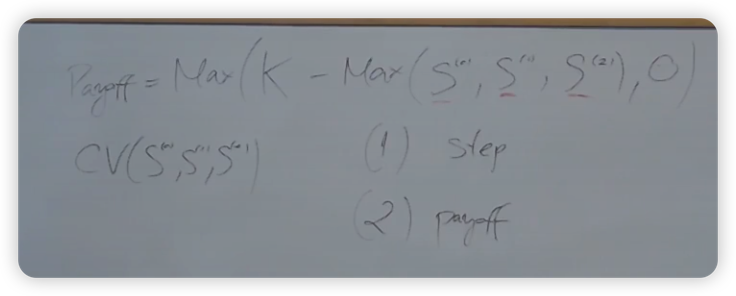

In [1]:
import jax.numpy as jnp
import jax
import haiku as hk
import optax

optimizer = optax.adam
lr = 1e-4


Spot = jnp.array([38, 36, 35])   # stock price
σ = jnp.array([0.2, .25, .3])     # stock volatility
K = 40      # strike price
r = 0.06    # risk free rate
n = 100000  # Number of simualted paths
batch_size = 512
m = 50      # number of exercise dates
T = 1       # maturity
order = 12   # Polynmial order
Δt = T / m  # interval between two exercise dates

n_stocks = 3

# simulates one step of the stock price evolution


def step(S, rng):
    ϵ = jax.random.normal(rng, S.shape)
    dB = jnp.sqrt(Δt) * ϵ
    S = S + r * S * Δt + σ * S * dB
    return S, S


def payoff_put(S):
    return jnp.maximum(K - jnp.maximum(S, 1), 0.)


def model(Si):
    out = (Si - 37.) / 5
    out = hk.Linear(64)(out)
    out = jax.nn.relu(out)

    out = hk.Linear(64)(out)
    out = jax.nn.relu(out)

    out = hk.Linear(1)(out)
    out = jnp.squeeze(out)
    return out


init, model = hk.without_apply_rng(hk.transform(model))

In [2]:
rng = jax.random.PRNGKey(0)
Θ = init(rng, jnp.ones([batch_size, n_stocks]))


def stack(Θ):
    return jnp.stack([Θ] * 49)


Θ = jax.tree_map(stack, Θ)

opt_state = optimizer(lr).init(Θ)

In [3]:
# LSMC algorithm
def compute_price(Θ, batch_size, rng):
    S = jnp.column_stack([jnp.ones(batch_size) * Spot[i] for i in range(3)])

    rng_vector = jax.random.split(rng, m)
    _, S = jax.lax.scan(step, S, rng_vector)

    discount = jnp.exp(-r * Δt)

    # Very last date
    value_if_exercise = payoff_put(S[-1])
    discounted_future_cashflows = value_if_exercise * discount

    def core(state, input):
        discounted_future_cashflows = state
        Si, Θi = input
        Y = discounted_future_cashflows
        value_if_wait = model(Θi, Si)

        mse = jnp.mean((value_if_wait - discounted_future_cashflows)**2)
        value_if_exercise = payoff_put(Si)
        exercise = value_if_exercise >= value_if_wait
        discounted_future_cashflows = discount * jnp.where(
            exercise,
            value_if_exercise,
            discounted_future_cashflows)

        return discounted_future_cashflows, mse

    # Proceed recursively
    S = jnp.flip(S, 0)[1:]
    inputs = S, Θ
    discounted_future_cashflows, mse = jax.lax.scan(
        core, discounted_future_cashflows, inputs)

    return discounted_future_cashflows.mean(), mse

In [4]:
def L(Θ, rng):
    mse = compute_price(Θ, batch_size, rng)[1]
    return mse.sum()


@jax.jit
def gradient_descent_step(Θ, opt_state, rng):
    rng, _ = jax.random.split(rng)
    grad = jax.grad(L)(Θ, rng)
    updates, opt_state = optimizer(lr).update(grad, opt_state)
    Θ = optax.apply_updates(Θ, updates)
    return Θ, opt_state, rng


@jax.jit
def evaluation(Θ):
    rng = jax.random.PRNGKey(0)
    return compute_price(Θ, n, rng)[0]

In [5]:
rng = jax.random.PRNGKey(0)

for iteration in range(10000):
    Θ, opt_state, rng = gradient_descent_step(Θ, opt_state, rng)

    if iteration % 100 == 0:
        metric = evaluation(Θ)
        print(metric)

ValueError: Incompatible shapes for broadcasting: ((1, 512), (512, 3))